## Copy the Data from Google drive

In [1]:
!nvidia-smi

Mon Aug 23 14:22:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/rohitrnath/DERBI-Hackathon-Challenge_DCoders
%cd DERBI-Hackathon-Challenge_DCoders

Cloning into 'DERBI-Hackathon-Challenge_DCoders'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [3]:
# !cp -rf "/content/drive/MyDrive/NIH_Dataset_Customised/NIH_Valid.zip" "/content/"
!cp -rf "/content/drive/MyDrive/NIH_Dataset_Customised/NIG_Custom_224.zip" "/content/DERBI-Hackathon-Challenge_DCoders"

In [4]:
# !unzip NIH_Valid.zip
!unzip NIG_Custom_224.zip

Streaming output truncated to the last 5000 lines.
 extracting: images/00028533_000.png  
 extracting: images/00010784_000.png  
 extracting: images/00022055_004.png  
 extracting: images/00008943_007.png  
 extracting: images/00027542_010.png  
 extracting: images/00011098_000.png  
 extracting: images/00008728_000.png  
 extracting: images/00007009_000.png  
 extracting: images/00000796_003.png  
 extracting: images/00018254_002.png  
 extracting: images/00015799_027.png  
 extracting: images/00016079_000.png  
 extracting: images/00009242_001.png  
 extracting: images/00016319_001.png  
 extracting: images/00009798_017.png  
 extracting: images/00011460_012.png  
 extracting: images/00000242_001.png  
 extracting: images/00011391_034.png  
 extracting: images/00003227_000.png  
 extracting: images/00009691_017.png  
 extracting: images/00005390_000.png  
 extracting: images/00021277_015.png  
 extracting: images/00030152_009.png  
 extracting: images/00003320_003.png  
 extracting: 

In [5]:
!cp -rf "/content/drive/MyDrive/NIH_Dataset_Customised/train_set.csv" "/content/DERBI-Hackathon-Challenge_DCoders"
!cp -rf "/content/drive/MyDrive/NIH_Dataset_Customised/val_set.csv" "/content/DERBI-Hackathon-Challenge_DCoders"
!cp -rf "/content/drive/MyDrive/NIH_Dataset_Customised/test_set.csv" "/content/DERBI-Hackathon-Challenge_DCoders"

In [6]:
#!cp -rf "/content/drive/MyDrive/Theme_1/NIH CC DRD/Data_Entry_2017_v2020.csv" "/content/"

In [7]:
#!cp -rf "/content/drive/MyDrive/NIH_Dataset_Customised/NIH_Valid.csv" "/content/"

In [8]:
!ls images/ | wc -l

82020


## Import Libraries

In [9]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from operator import itemgetter
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import seaborn as sns
%matplotlib inline

## Load the Datasets

In [10]:
pathology_list = ['No Findings',
                  'Pneumothorax',
                  'Pneumonia',
                  'Edema',
                  'Effusion',
                  'Emphysema']


In [11]:

train_df = pd.read_csv("train_set.csv")
valid_df = pd.read_csv("val_set.csv")
test_df = pd.read_csv("test_set.csv")


valid_df.head()

Image Index  Patient ID  No Findings  ...  Edema  Effusion  Emphysema
0  00000001_001.png           1            0  ...      0         0          1
1  00000001_002.png           1            0  ...      0         1          0
2  00000008_001.png           8            1  ...      0         0          0
3  00000023_002.png          23            0  ...      0         1          0
4  00000023_003.png          23            1  ...      0         0          0

[5 rows x 8 columns]

### Find the mean and STD of the dataset

In [12]:

import time

DATA_DIR = "/content/images"
total = len(train_df)
mean = []
sd=[]

program_starts = time.time()
for idx in range(total):
    row = train_df.loc[idx]
    img_id = row['Image Index']
    img_fname = DATA_DIR + "/" + str(img_id)
    img = Image.open(img_fname).convert('RGB')
    imarr = np.array( img, dtype=np.float)
    mean.append(np.mean( imarr, axis=(0, 1)))
    sd.append(np.std( imarr, axis=(0, 1)))
    
print("Train set done within {} seconds".format((time.time() - program_starts)))
print("Number of train Images = ", len(mean))
print("[TrainSET] Mean = {}, STD= {}".format( np.mean(mean,  axis=0), np.std(sd,  axis=0) ))

total = len(valid_df)
for idx in range(total):
    row = valid_df.loc[idx]
    img_id = row['Image Index']
    img_fname = DATA_DIR + "/" + str(img_id)
    img = Image.open(img_fname).convert('RGB')
    imarr = np.array( img, dtype=np.float)
    mean.append(np.mean( imarr, axis=(0, 1)))
    sd.append(np.std( imarr, axis=(0, 1)))
    
print("Total set done within {} seconds".format((time.time() - program_starts)))
print("Number of Total Images = ", len(mean))
print("[Total] Mean = {}, STD= {}".format( np.mean(mean,  axis=0), np.std(sd,  axis=0) ))

## Addressing Class Imbalance
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

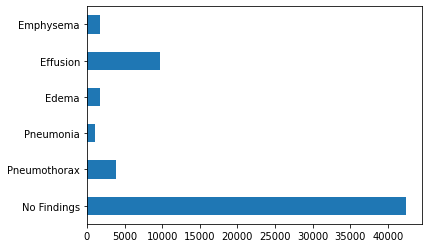

In [13]:
#train_df = train_df.drop(['No Findings'],axis = 1)
train_df = train_df.drop(['Patient ID'],axis = 1)
train_df.iloc[:,1:].sum().plot.barh()

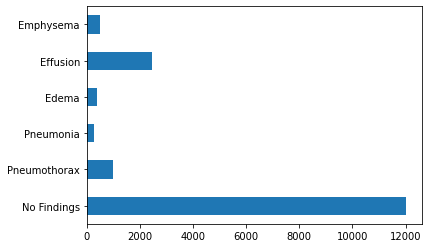

In [14]:
#valid_df = valid_df.drop(['No Findings'],axis = 1)
valid_df = valid_df.drop(['Patient ID'],axis = 1)
valid_df.iloc[:,1:].sum().plot.barh()

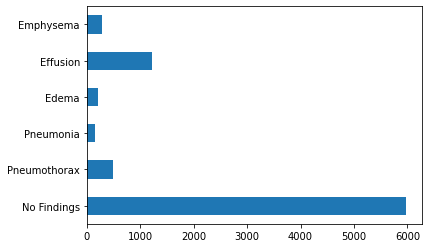

In [15]:
test_df = test_df.drop(['Patient ID'],axis = 1)
test_df.iloc[:,1:].sum().plot.barh()

### Computing Class Frequencies
calculate these frequences for each label in our dataset.

In [16]:
def compute_class_freqs(labels):

    labels = np.array(labels)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [17]:
freq_pos,freq_neg = compute_class_freqs(train_df.iloc[:,1:])

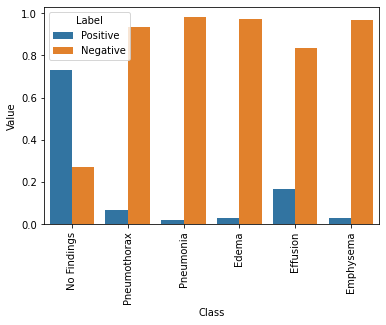

In [18]:
df = pd.DataFrame({"Class": pathology_list, "Label": "Positive", "Value": freq_pos})
df = df.append([{"Class": pathology_list[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=df)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same.

To have this, we want

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$
which we can do simply by taking

$$w_{pos} = freq_{neg}$$$$w_{neg} = freq_{pos}$$
This way, we will be balancing the contribution of positive and negative labels.

In [19]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [20]:
pos_weights, neg_weights

(array([0.26997743, 0.93385355, 0.98217146, 0.97066474, 0.83353143,
        0.97011352]),
 array([0.73002257, 0.06614645, 0.01782854, 0.02933526, 0.16646857,
        0.02988648]))

Let's verify this by graphing the two contributions next to each other again:

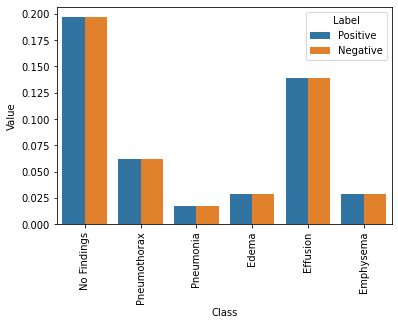

In [21]:
df = pd.DataFrame({"Class": pathology_list, "Label": "Positive", "Value": pos_contribution})
df = df.append([{"Class": pathology_list[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_contribution)], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=df)

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function.

After computing the weights, our final weighted loss for each training case will be

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

### Weighted Loss
weighted_loss function below to return a loss function that calculates the weighted loss for each batch. Recall that for the multi-class loss, we add up the average loss for each individual class. Note that we also want to add a small value, $\epsilon$, to the predicted values before taking their logs. This is simply to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.

In [22]:
def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon=1e-7):

    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

## Data Pre-Processing

### Data Augmentation

In [23]:
from dataloader import NIH_Dataset, get_default_device, to_device, DeviceDataLoader

In [ ]:
mean_list = [[ 0.4914168 , 0.4914168 , 0.4914168] , [0.485,0.456,0.406] , [0.9,0.9,0.9] , [127.17693561, 127.17693561, 127.17693561], 0.496 ]
std_list = [[0.407278, 0.407278 , 0.407278] , [0.229,0.224,0.225] , [0.9,0.9,0.9] , [10.95304313, 10.95304313, 10.95304313], 0.407278]

mean = mean_list[1]
std=  std_list[1]

#### Torchvision based data Augmentation

In [25]:
Mean = [ 0.498733, 0.498733, 0.498733]#, 127.72887278/255]
STD= [0.04295311, 0.04295311, 0.04295311]#, 11.73750802/255]
# Mean = [127.41869931/255.0]
# STD= [10.98167434/255.0]
train_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
    #T.Normalize(mean=[0.485], std=[0.229])
])

valid_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
    #T.Normalize(mean=[0.485], std=[0.229])
])

In [26]:
#Sample dataset with torchvision transform applied
trainds = NIH_Dataset(train_df,
                      img_dir = 'images/',
                      transform = train_transform)

#### Albumentation based data Augmentation

In [24]:
import albumentations

import torch
from albumentations import (ToFloat, Resize, PadIfNeeded, RandomCrop, Rotate,
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, OneOf, Compose, Cutout
)

from albumentations.pytorch import ToTensor

from albumentations import ImageOnlyTransform

import matplotlib.pyplot as plt

seed = 42

import pandas as pd
import os
import cv2


alb_train = Compose([Resize(224,224), 
                      OneOf([CLAHE(clip_limit=4),
                      IAASharpen(),
                      Rotate(),
                      IAAEmboss(),
                      Transpose(),
                      RandomContrast(),
                      RandomBrightness(),
                      Cutout()
                      ],p=0.3),
                    albumentations.Normalize(mean= mean ,std= std),
                    ToTensor()
                ])

alb_test = Compose([Resize(224,224),
                    albumentations.Normalize(mean= mean ,std= std),
                    ToTensor()
                            ])

In [28]:
#Sample dataset with albumentation transform applied
traindalb = NIH_Dataset(train_df,
                      img_dir = 'images/',
                      aug = alb_transform)

### Load data to Dataloader

#### Load the dataset with augmentation

In [27]:
train_ds = NIH_Dataset(train_df,
                      img_dir = 'images/',
                      transform = train_transform)
val_ds = NIH_Dataset(valid_df,
                      img_dir = 'images/',
                      transform = valid_transform)
test_ds = NIH_Dataset(test_df,
                      img_dir = 'images/',
                      transform = valid_transform)

In [29]:
len(trainds)

58053

#### Show sample image from dataset

In [89]:
from utils import show_sample

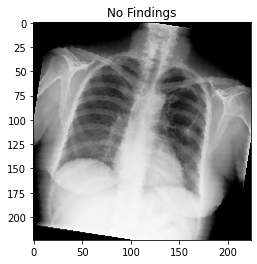

In [90]:
show_sample(*trainds[4])

#### Apply dataloader

In [95]:
batch_size = 88
train_dl = DataLoader(trainds, batch_size, shuffle=True, 
                      num_workers=4, pin_memory=True)


train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, 
                    num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True, 
                      num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [96]:
from utils import show_batch

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


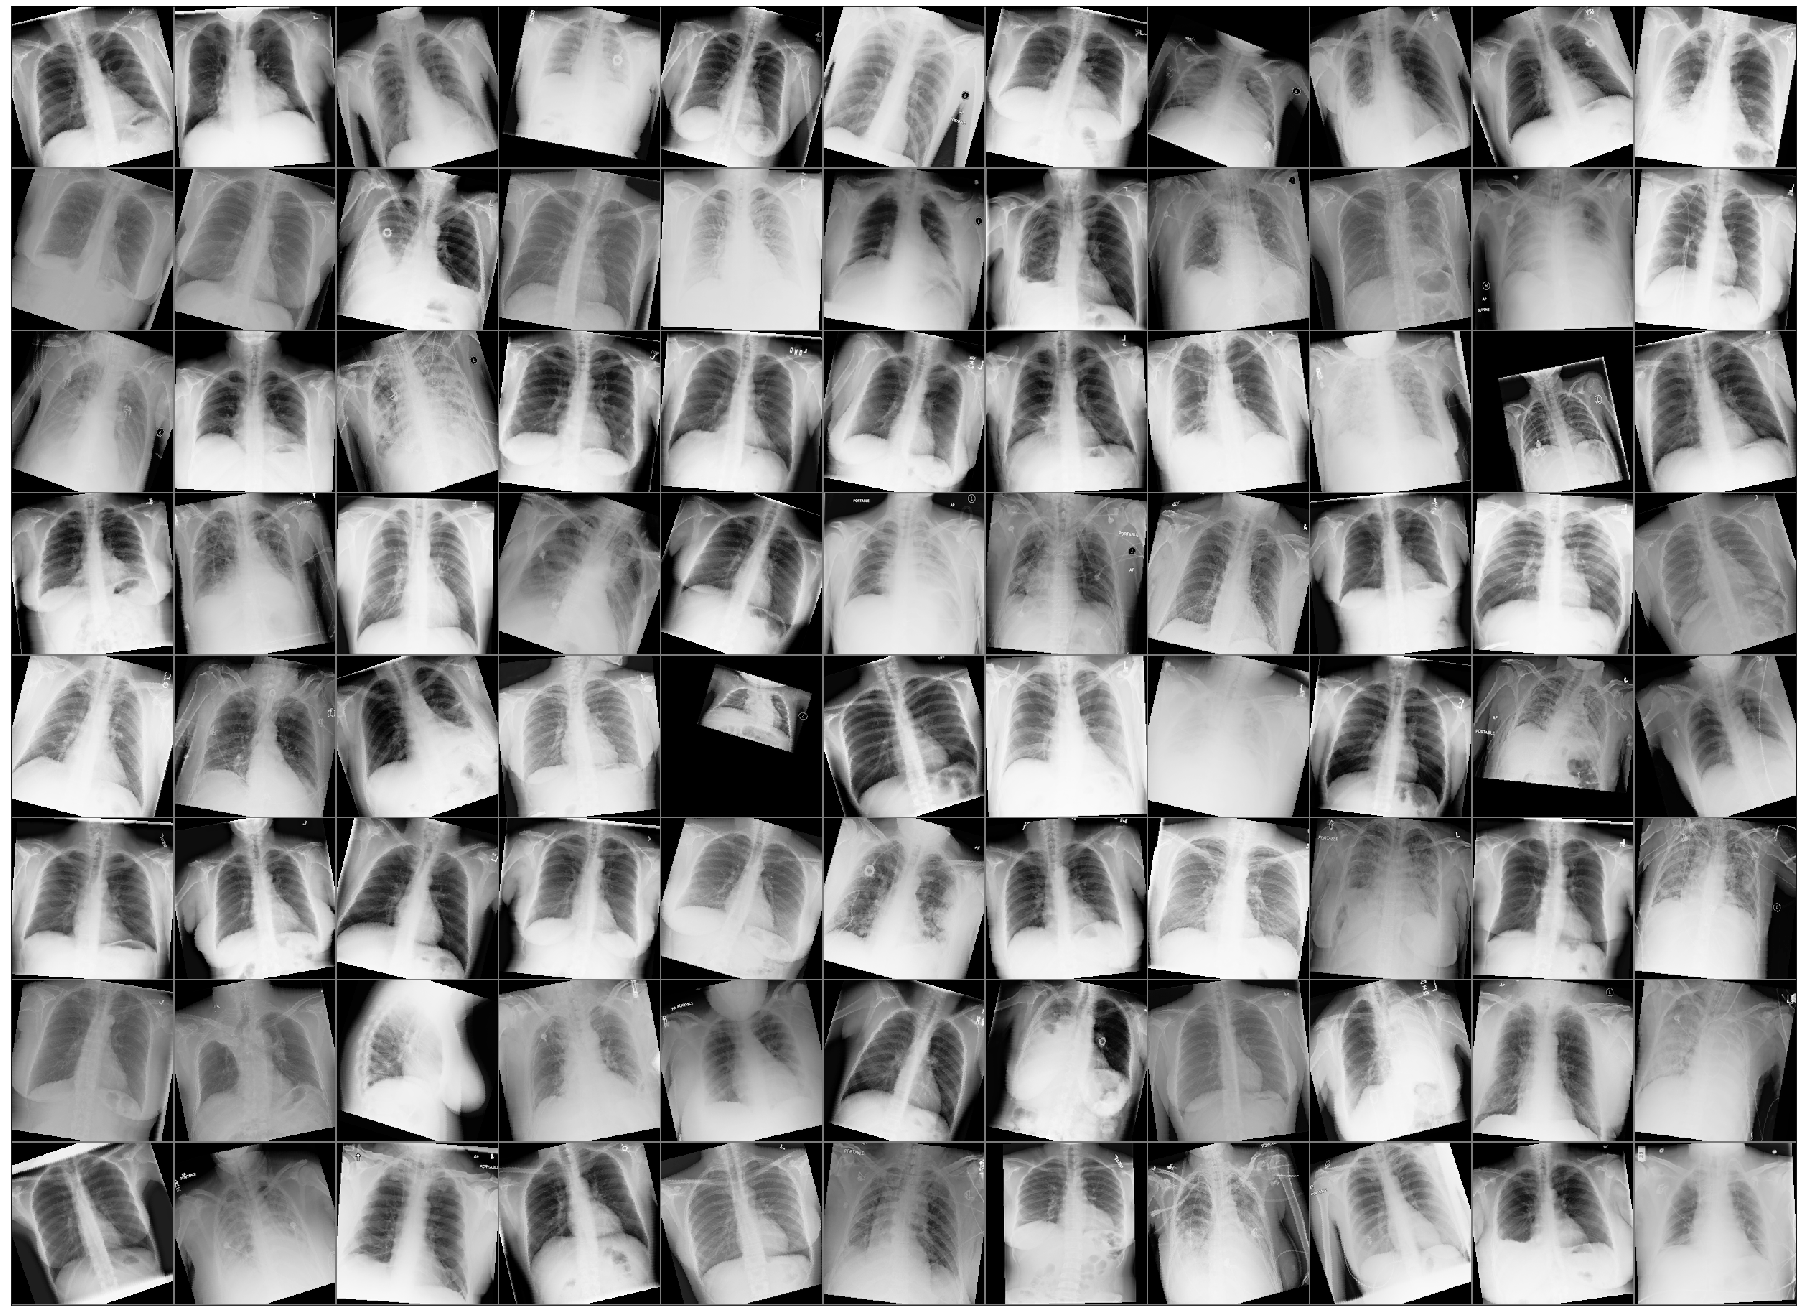

In [97]:
show_batch(train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


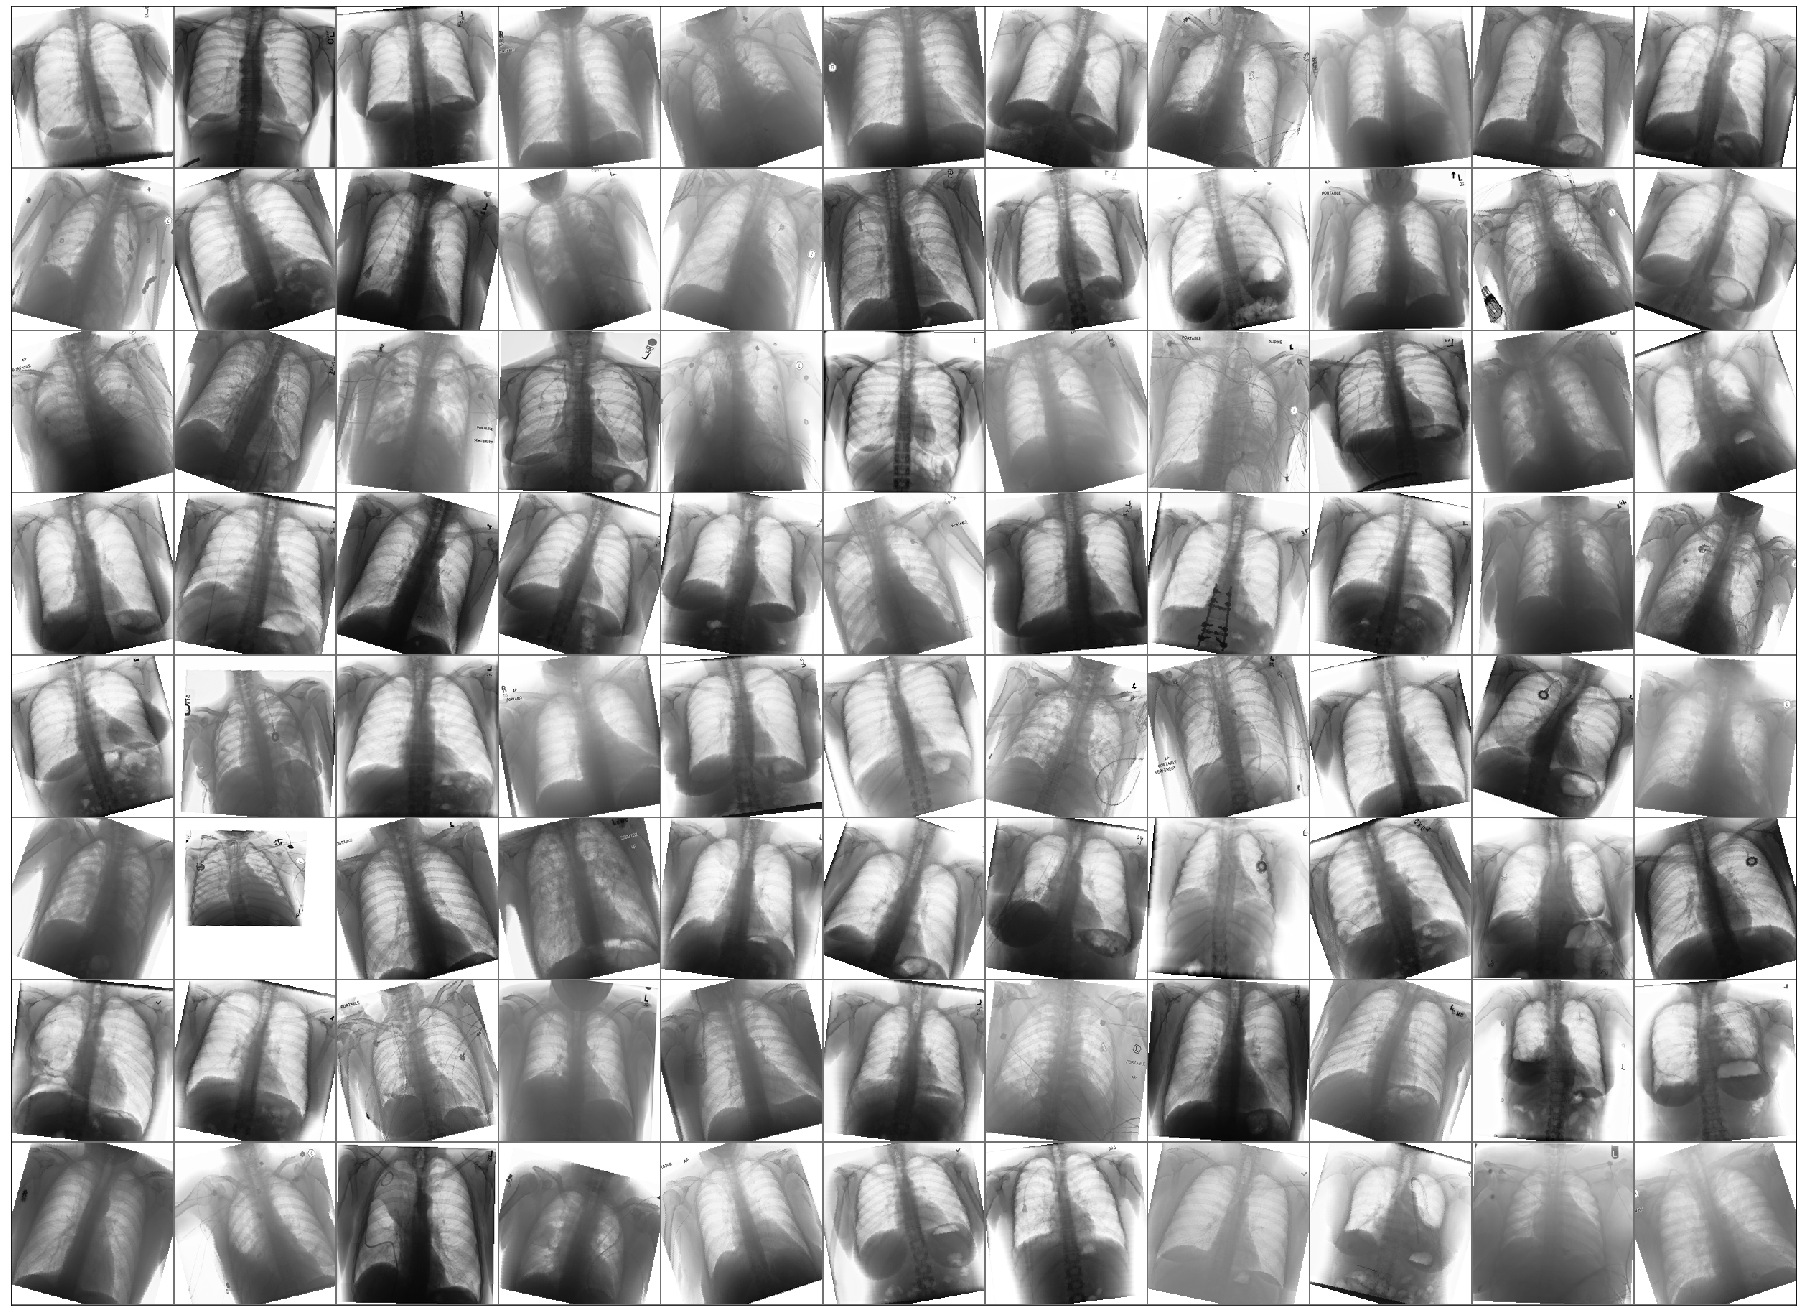

In [98]:
#Show inverted image
show_batch(train_dl, invert=True)

In [105]:
device = get_default_device()
device

device(type='cuda')

In [106]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

## Model - Transfer Learning

In [37]:
from basemodel import MultilabelImageClassificationBase

class chestXRayNet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.densenet121()
        # Replace last layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, 6)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

## Training

In [44]:
from train import evaluate, get_lr, fit_one_cycle

In [112]:
model = to_device(chestXRayNet(), device)
# model.load_state_dict(torch.load('/content/drive/MyDrive/DCoders/densenet121/densenet121-7406.pth'))

<All keys matched successfully>

In [108]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_loss': 0.6475250720977783, 'val_score': 0.19980603456497192}]

#### Hyper parameters

In [ ]:
epochs = 15
max_lr = 0.01
grad_clip = 1
weight_decay = 1e-4
opt_func = torch.optim.SGD

#### First 15 epoch with cyclic lr policy

In [ ]:
%%time
history += fit_one_cycle( epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/692 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.0069, train_loss: 0.5096, val_loss: 0.4511, val_score: 0.6811


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0036, train_loss: 0.4537, val_loss: 0.4368, val_score: 0.6608


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0003, train_loss: 0.4397, val_loss: 0.4306, val_score: 0.6718


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0072, train_loss: 0.4341, val_loss: 0.4205, val_score: 0.6770


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0038, train_loss: 0.4187, val_loss: 0.4090, val_score: 0.6942


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0005, train_loss: 0.4094, val_loss: 0.4077, val_score: 0.6991


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0074, train_loss: 0.4083, val_loss: 0.4082, val_score: 0.7216


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0041, train_loss: 0.3979, val_loss: 0.4010, val_score: 0.7129


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0007, train_loss: 0.3891, val_loss: 0.3981, val_score: 0.7071


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0076, train_loss: 0.3880, val_loss: 0.3996, val_score: 0.7147


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.0043, train_loss: 0.3802, val_loss: 0.3978, val_score: 0.7037


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.0010, train_loss: 0.3717, val_loss: 0.3982, val_score: 0.7080


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.0079, train_loss: 0.3709, val_loss: 0.4031, val_score: 0.7261


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.0045, train_loss: 0.3661, val_loss: 0.4001, val_score: 0.7094


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.0012, train_loss: 0.3533, val_loss: 0.4099, val_score: 0.7183
best accuracy = 0.7261263132095337
CPU times: user 1h 17min 16s, sys: 1h 15min 22s, total: 2h 32min 38s
Wall time: 2h 40min


#### 10 Epochs with One cycle LR policy

In [ ]:
%%time
history += fit_one_cycle(10, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip,
                         opt_func=torch.optim.Adam)

  0%|          | 0/692 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.0003, train_loss: 0.3977, val_loss: 0.4353, val_score: 0.6295


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0008, train_loss: 0.4261, val_loss: 0.4554, val_score: 0.7086


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0010, train_loss: 0.4294, val_loss: 0.4586, val_score: 0.5682


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0010, train_loss: 0.4218, val_loss: 0.4869, val_score: 0.7250


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0008, train_loss: 0.4090, val_loss: 0.3984, val_score: 0.6563


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0006, train_loss: 0.3983, val_loss: 0.4064, val_score: 0.7429


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0004, train_loss: 0.3802, val_loss: 0.3984, val_score: 0.7320


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0002, train_loss: 0.3576, val_loss: 0.3877, val_score: 0.7271


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0000, train_loss: 0.3276, val_loss: 0.3984, val_score: 0.7229


  0%|          | 0/692 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0000, train_loss: 0.2981, val_loss: 0.4176, val_score: 0.7406
best accuracy = 0.7428826689720154
CPU times: user 54min 15s, sys: 49min 19s, total: 1h 43min 34s
Wall time: 1h 48min 28s


## Result Analysis

In [ ]:
from utils import plot_scores

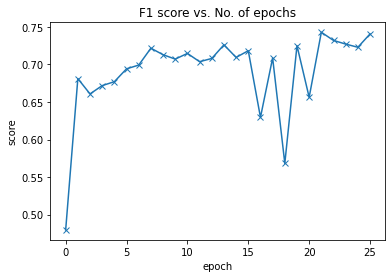

In [ ]:
plot_scores(history)

In [ ]:
from utils import plot_losses

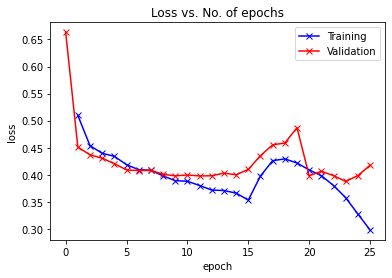

In [ ]:
plot_losses(history)

In [ ]:
from utils import plot_losses

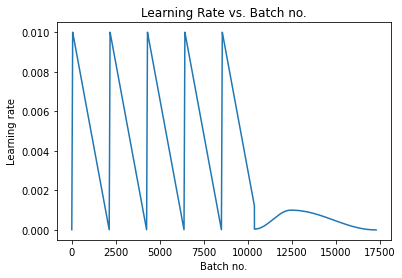

In [ ]:
plot_lrs(history)

### Individual Class Accuracy

In [73]:
from utils import class_accuracy, get_acc_data

In [76]:
print("Training Dataset Accuracy Report")
acc_list = class_accuracy(train_dl, model, train_df)
get_acc_data(pathology_list,acc_list)

Training Dataset Accuracy Report


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Labels        Acc
0   No Findings  84.734639
1  Pneumothorax  87.258195
2     Pneumonia  82.932837
3         Edema  89.833428
4      Effusion  87.551031
5     Emphysema  91.729971

In [75]:
print("Validation Dataset Accuracy Report")
acc_list = class_accuracy(val_dl, model, valid_df)
get_acc_data(pathology_list,acc_list)

Validation Dataset Accuracy Report


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Labels        Acc
0   No Findings  82.044061
1  Pneumothorax  88.089874
2     Pneumonia  82.657404
3         Edema  89.723370
4      Effusion  85.304794
5     Emphysema  93.578671

In [74]:
print("Test Dataset Accuracy Report")
acc_list = class_accuracy(test_dl, model, test_df)
get_acc_data(pathology_list,acc_list)

Test Dataset Accuracy Report


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Labels        Acc
0   No Findings  81.524596
1  Pneumothorax  87.582927
2     Pneumonia  82.338215
3         Edema  89.097509
4      Effusion  85.217174
5     Emphysema  93.253223

### ROC Score  

In [1]:
from utils import roc_score, get_roc_curve

ModuleNotFoundError: No module named 'utils'

#### ROC curve for test dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


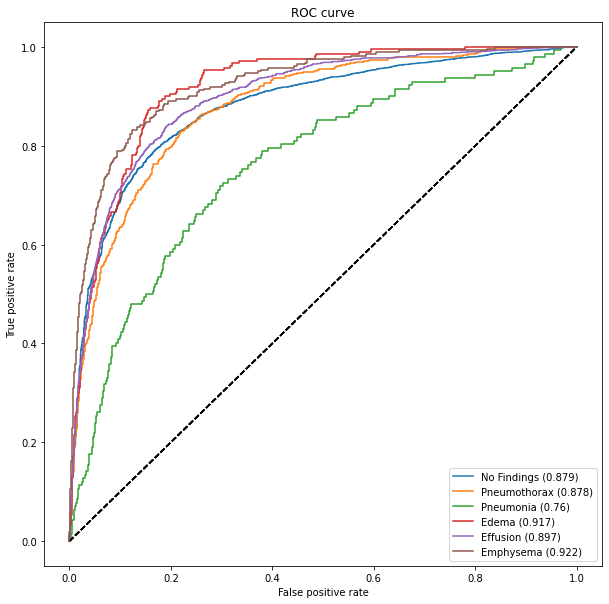

[0.8788879900025546,
 0.8783985997845822,
 0.75958426742435,
 0.9173617615191082,
 0.8970559341507748,
 0.9220444013856012]

In [70]:
outs, labs = roc_score(test_dl, model, test_df)
get_roc_curve(pathology_list, outs, labs)

#### ROC curve for train dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


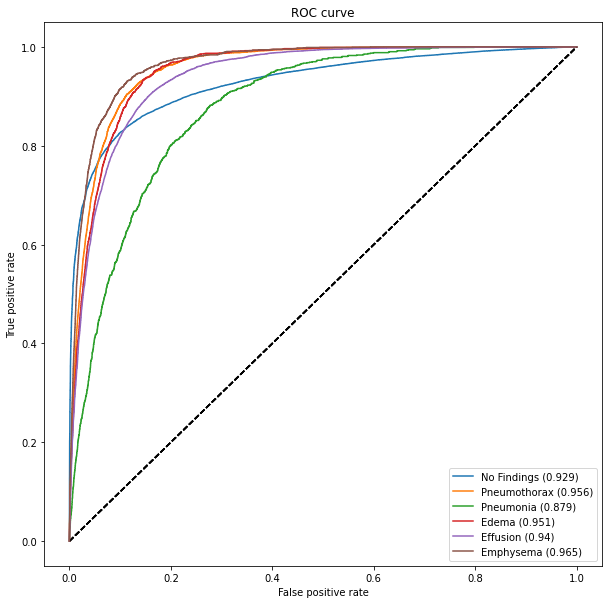

[0.928516218845833,
 0.9557773418045488,
 0.8786549141274651,
 0.9514505692496305,
 0.9401704200738522,
 0.9649054826887212]

In [77]:
outs, labs = roc_score(train_dl, model, train_df)
get_roc_curve(pathology_list, outs, labs)

## Model Inferencing with GradCAM Visualization

In [48]:
from visualizer import visualizer

tensor([[0.1985, 0.3464, 0.5698, 0.8720, 0.8328, 0.3112]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


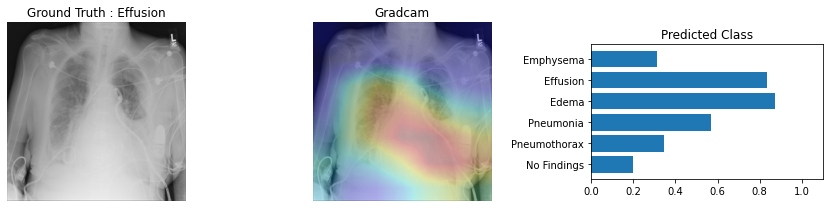

In [113]:
image,label = test_ds[21]
visualizer( model, image, label, mean, std)

tensor([[0.4482, 0.0404, 0.9595, 0.9597, 0.0344, 0.0107]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


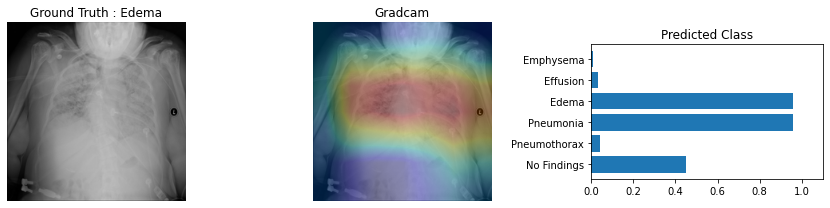

In [114]:
image,label = test_ds[121]
visualizer( model, image, label, mean, std)

tensor([[0.7586, 0.0912, 0.2267, 0.1085, 0.3118, 0.0081]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


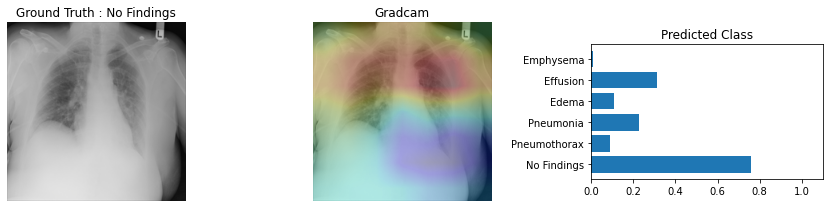

In [115]:
image,label = test_ds[1]
visualizer( model, image, label, mean, std)

tensor([[0.2198, 0.7167, 0.3101, 0.0749, 0.8086, 0.2943]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


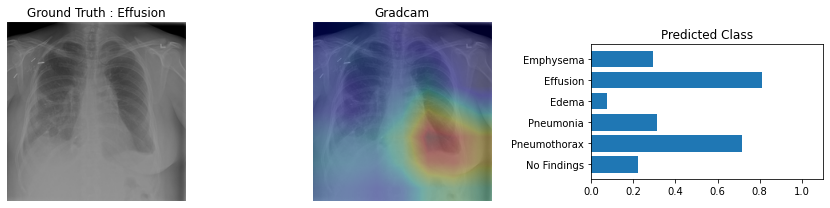

In [117]:
image,label = test_ds[333]
visualizer( model, image, label, mean, std)

tensor([[8.6631e-01, 5.3303e-04, 1.3523e-01, 4.0221e-03, 3.9259e-02, 9.1758e-01]],
       device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


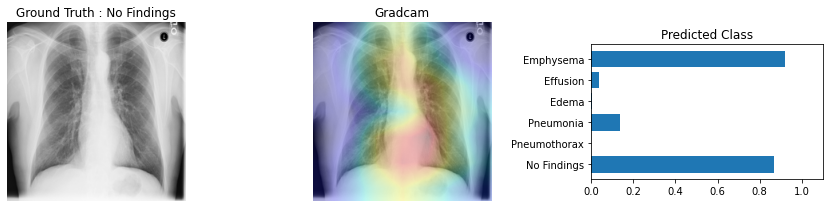

In [116]:
image,label = test_ds[2]
visualizer( model, image, label, mean, std)

tensor([[0.9604, 0.0136, 0.0092, 0.3359, 0.0291, 0.0093]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


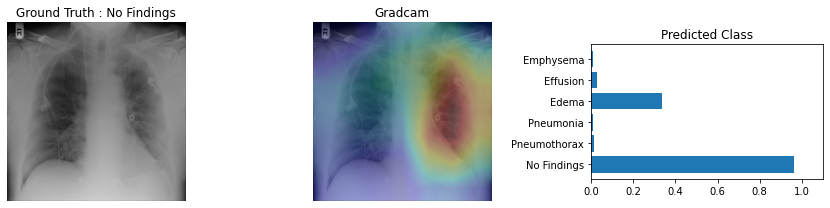

In [118]:
image,label = test_ds[444]
visualizer( model, image, label, mean, std)

tensor([[0.9658, 0.0027, 0.0376, 0.0163, 0.0842, 0.0099]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


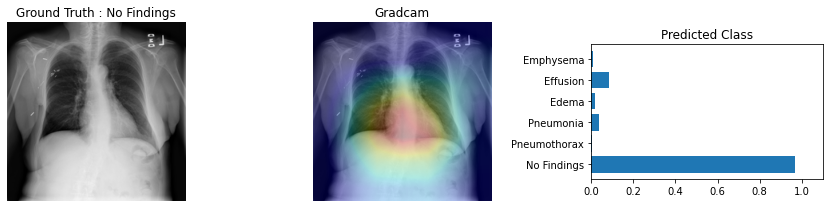

In [131]:
image,label = test_ds[111]
visualizer( model, image, label, mean, std)

## Save model weights to deploy

In [40]:
torch.save(model.cpu().state_dict(), 'model.pth')